# Analyse de sentiment sur les tweets financiers

Ce notebook présente une analyse complète du dataset Kaggle : Stock Tweets for Sentiment Analysis and Prediction

### 1. Installation des packages nécessaires

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

### 2. Chargement des données


In [25]:
path1 ="C:/Users/aucea/Documentos/EFREI/M2/S9/Deep Learning/dataset/stock_tweets.csv"
path2 ="C:/Users/aucea/Documentos/EFREI/M2/S9/Deep Learning/dataset/stock_yfinance_data.csv"

finance_data = pd.read_csv(path2)
tweets_data = pd.read_csv(path1)

In [26]:
# Vérification du chargement
print("Aperçu des tweets :")
print(tweets_data.head())

print("\nAperçu des données financières :")
print(finance_data.head())


Aperçu des tweets :
                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  

Aperçu des données financières :
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.70666

In [27]:
# Informations générales sur le dataset
tweets_data.info()

# Dimensions du dataset (lignes, colonnes)
print("\nDimensions du dataset :", tweets_data.shape)

# Aperçu des 10 premières lignes
tweets_data.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

Dimensions du dataset : (80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
5,2022-09-29 22:25:53+00:00,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc."
6,2022-09-29 22:24:22+00:00,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc."
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc."
8,2022-09-29 22:23:28+00:00,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc."
9,2022-09-29 22:15:01+00:00,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc."


In [28]:
# Vérification des valeurs manquantes
tweets_data.isnull().sum()


Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64

### 3. Analyse Exploratoire Des données (EDA)

In [29]:
# Assurez-vous que la colonne date est bien au format datetime
tweets_data['Date'] = pd.to_datetime(tweets_data['Date'])

In [30]:
# Aperçu général
print("Dimensions du dataset :", tweets_data.shape)
print("\nColonnes disponibles :", tweets_data.columns.tolist())
print("\nAperçu des données :")
display(tweets_data.head())

Dimensions du dataset : (80793, 4)

Colonnes disponibles : ['Date', 'Tweet', 'Stock Name', 'Company Name']

Aperçu des données :


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [31]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(tweets_data.isnull().sum())


Valeurs manquantes par colonne :
Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64


### Analyse de sentiment avec VADER

In [32]:
%pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# On initialise l'analyseur de sentiment VADER
analyzer = SentimentIntensityAnalyzer()

# Fonction qui retourne à la fois le score et le label
def compute_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        label = 'Positive'
    elif score <= -0.05:
        label = 'Negative'
    else:
        label = 'Neutral'
    return score, label

# On applique la fonction
tweets_data[['Sentiment_Score', 'Sentiment']] = tweets_data['Tweet'].apply(
    lambda x: pd.Series(compute_sentiment(x))
)

# Vérifions les nouvelles colonnes
tweets_data.head()

Note: you may need to restart the kernel to use updated packages.


,Date,Tweet,Stock Name,Company Name,Sentiment_Score,Sentiment
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772,Positive
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0000,Neutral
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.2960,Positive
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568,Negative
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.8750,Negative


In [33]:
# Statistiques descriptives sur les sentiments
print("\nRépartition des sentiments :")
print(tweets_data['Sentiment'].value_counts(normalize=True).round(3))



Répartition des sentiments :
Sentiment
Positive    0.514
Neutral     0.280
Negative    0.205
Name: proportion, dtype: float64


In [34]:
# Comptage des labels de sentiment
tweets_data['Sentiment'].value_counts()
tweets_data['Sentiment'].value_counts(normalize=True) * 100

Sentiment
Positive    51.420296
Neutral     28.046984
Negative    20.532719
Name: proportion, dtype: float64

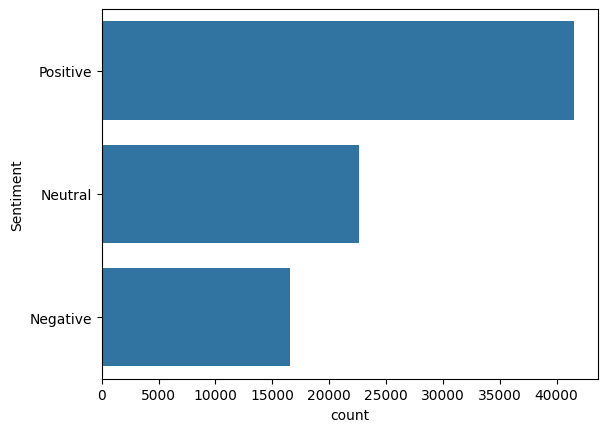

In [35]:
sns.countplot(tweets_data['Sentiment'])
plt.show()

In [36]:
# Statistiques descriptives sur la colonne sentiment
tweets_data['Sentiment'].value_counts()

# Affichage en pourcentage
tweets_data['Sentiment'].value_counts(normalize=True) * 100


Sentiment
Positive    51.420296
Neutral     28.046984
Negative    20.532719
Name: proportion, dtype: float64

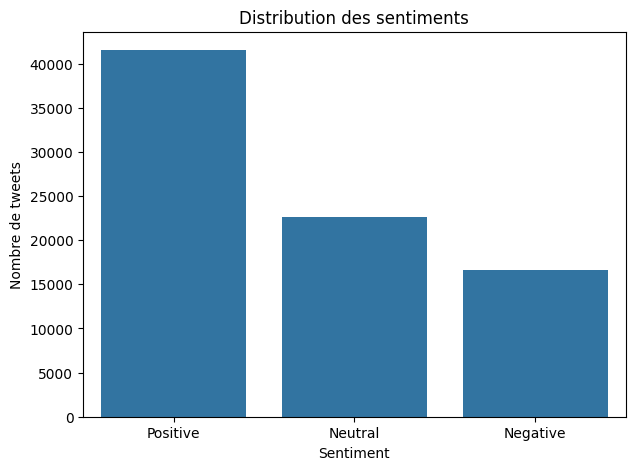

In [37]:
# Visualisation distribution des sentiments
plt.figure(figsize=(7,5))
sns.countplot(data=tweets_data, x='Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Distribution des sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de tweets")
plt.show()

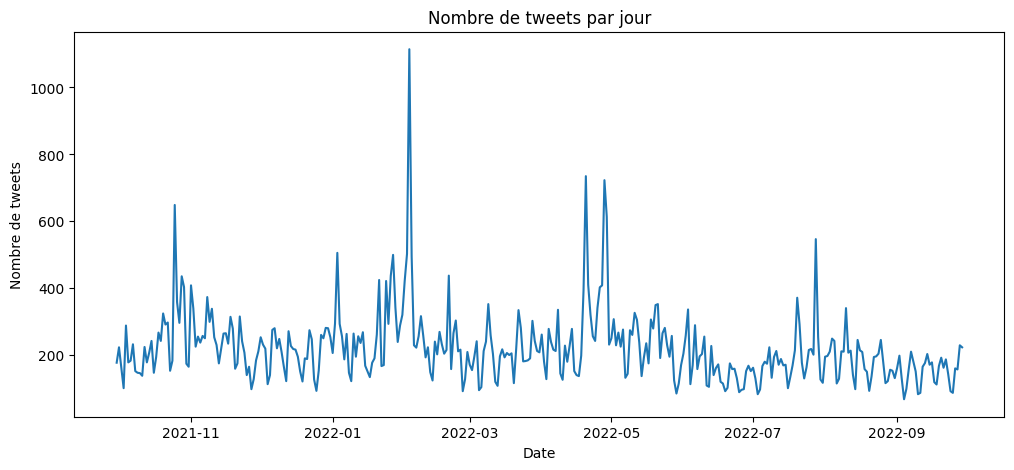

In [38]:
# Analyse temporelle : nombre de tweets par jour
tweets_per_day = tweets_data.groupby(tweets_data['Date'].dt.date).size()
plt.figure(figsize=(12,5))
tweets_per_day.plot()
plt.title("Nombre de tweets par jour")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.show()

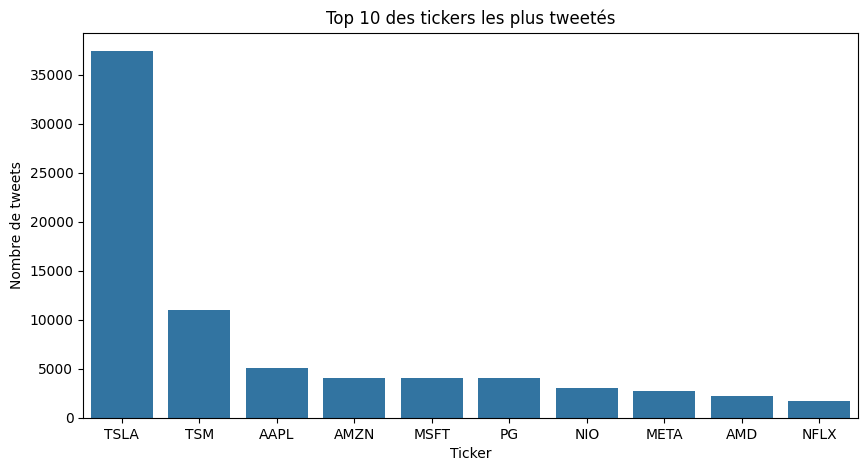

In [39]:
# Analyse des tweets par ticker (top 10 tickers les plus tweetés)
top_tickers = tweets_data['Stock Name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_tickers.index, y=top_tickers.values)
plt.title("Top 10 des tickers les plus tweetés")
plt.xlabel("Ticker")
plt.ylabel("Nombre de tweets")
plt.show()

### Nettoyage simple des tweets pour analyse textuelle

In [40]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aucea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Liste des stopwords anglais
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r'http\S+', '', text)  # Supprimer les URLs
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions
    text = re.sub(r'#', '', text)  # Supprimer le # mais garder le mot
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces multiples
    # Supprimer les stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Création d'une nouvelle colonne Clean_Tweet
tweets_data['Clean_Tweet'] = tweets_data['Tweet'].apply(clean_text)

# Vérifions
tweets_data[['Tweet', 'Clean_Tweet']].head(10)


,Tweet,Clean_Tweet
0,Mainstream media has done an amazing job at br...,mainstream media done amazing job brainwashing...
1,Tesla delivery estimates are at around 364k fr...,tesla delivery estimates around k analysts tsla
2,3/ Even if I include 63.0M unvested RSUs as of...,even include unvested rsus additional equity n...
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,hahaha still trying stop tesla fsd bro get shi...
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",stop trying kill kids sad deranged old man
5,@RealDanODowd @Tesla This is you https://t.co/...,
6,For years @WholeMarsBlog viciously silenced @T...,years viciously silenced critics failing silen...
7,$NIO just because I'm down money doesn't mean ...,nio im money doesnt mean bad investment whole ...
8,50 likes for some $SPY $TSLA charts to study!\...,likes spy tsla charts study
9,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,powerwalls waterproof could bad wiring house c...


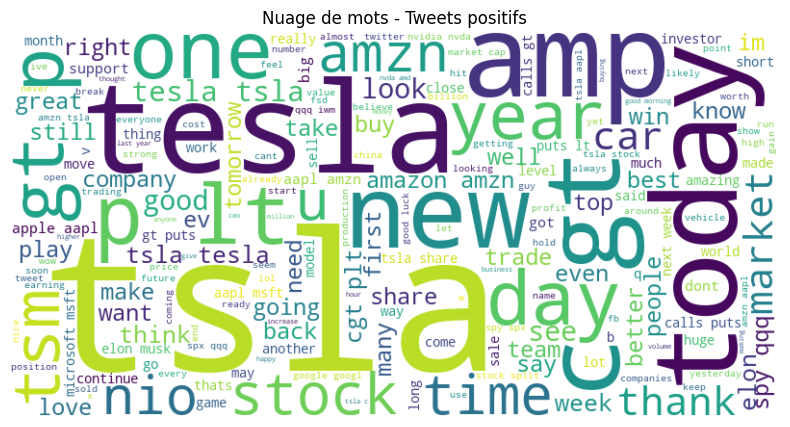

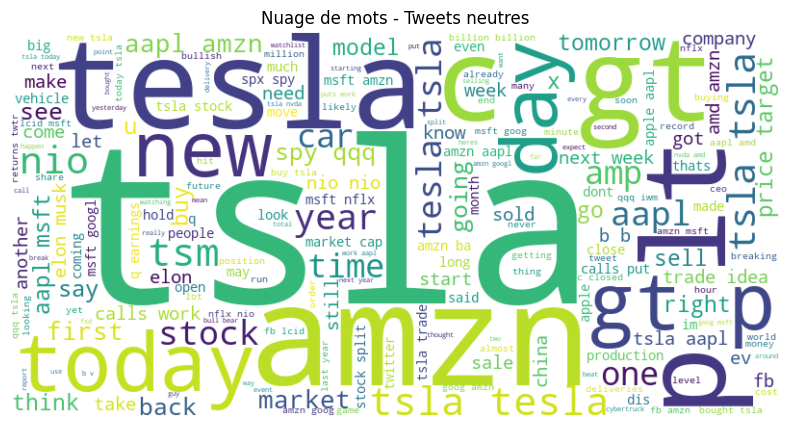

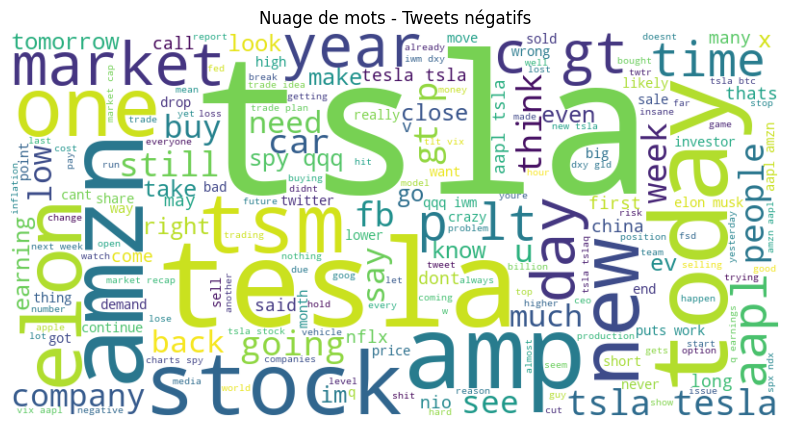

In [42]:
# Nuages de mots par sentiment
def plot_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(tweets_data[tweets_data['Sentiment']=='Positive']['Clean_Tweet'], "Nuage de mots - Tweets positifs")
plot_wordcloud(tweets_data[tweets_data['Sentiment']=='Neutral']['Clean_Tweet'], "Nuage de mots - Tweets neutres")
plot_wordcloud(tweets_data[tweets_data['Sentiment']=='Negative']['Clean_Tweet'], "Nuage de mots - Tweets négatifs")


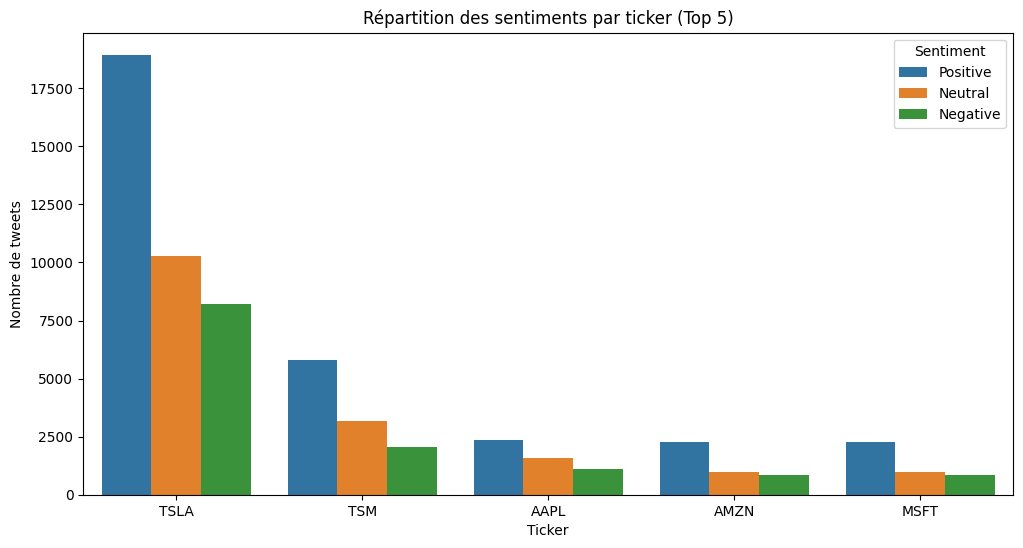

In [43]:
# Analyse des sentiments par ticker (top 5 tickers)
top5 = top_tickers.index[:5]
plt.figure(figsize=(12,6))
sns.countplot(data=tweets_data[tweets_data['Stock Name'].isin(top5)], x='Stock Name', hue='Sentiment',
              order=top5, hue_order=['Positive', 'Neutral', 'Negative'])
plt.title("Répartition des sentiments par ticker (Top 5)")
plt.xlabel("Ticker")
plt.ylabel("Nombre de tweets")
plt.show()

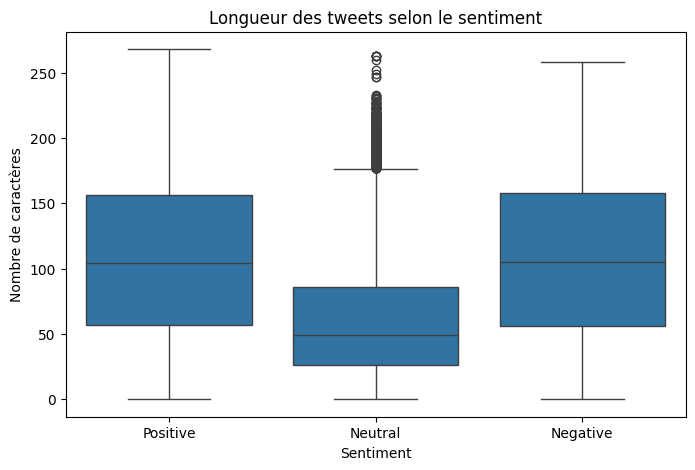

In [44]:
# Analyse de la longueur des tweets par sentiment
tweets_data['tweet_length'] = tweets_data['Clean_Tweet'].apply(len)
plt.figure(figsize=(8,5))
sns.boxplot(data=tweets_data, x='Sentiment', y='tweet_length', order=['Positive', 'Neutral', 'Negative'])
plt.title("Longueur des tweets selon le sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de caractères")
plt.show()

In [45]:
# Statistiques descriptives sur la longueur des tweets
print("\nStatistiques sur la longueur des tweets par sentiment :")
print(tweets_data.groupby('Sentiment')['tweet_length'].describe())



Statistiques sur la longueur des tweets par sentiment :
             count        mean        std  min   25%    50%    75%    max
Sentiment                                                                
Negative   16589.0  107.725360  57.837577  0.0  56.0  105.0  158.0  258.0
Neutral    22660.0   63.352957  49.037717  0.0  26.0   49.0   86.0  263.0
Positive   41544.0  106.493525  56.783802  0.0  57.0  104.0  156.0  268.0


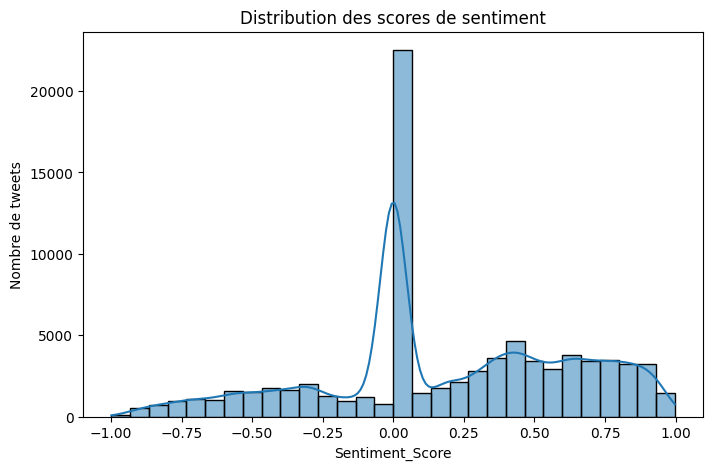

In [46]:
# Analyse du Sentiment_Score (distribution)
plt.figure(figsize=(8,5))
sns.histplot(tweets_data['Sentiment_Score'], bins=30, kde=True)
plt.title("Distribution des scores de sentiment")
plt.xlabel("Sentiment_Score")
plt.ylabel("Nombre de tweets")
plt.show()

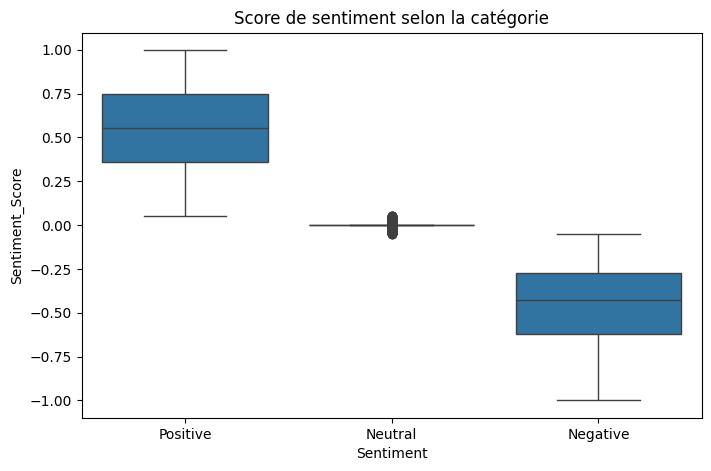

In [47]:
# Corrélation entre Sentiment_Score et sentiment catégoriel
plt.figure(figsize=(8,5))
sns.boxplot(data=tweets_data, x='Sentiment', y='Sentiment_Score', order=['Positive', 'Neutral', 'Negative'])
plt.title("Score de sentiment selon la catégorie")
plt.xlabel("Sentiment")
plt.ylabel("Sentiment_Score")
plt.show()

In [49]:
# Exemple de conversion date au bon format
finance_data['Date'] = pd.to_datetime(finance_data['Date'])


### 4. Préparation des données pour analyse croisée

In [50]:
tweets_agg = tweets_data.groupby(['Date', 'Stock Name']).agg(
    tweet_count=('Tweet', 'count'),
    avg_sentiment_score=('Sentiment_Score', 'mean'),
    positive_tweets=('Sentiment', lambda x: (x=='Positive').sum()),
    neutral_tweets=('Sentiment', lambda x: (x=='Neutral').sum()),
    negative_tweets=('Sentiment', lambda x: (x=='Negative').sum())
).reset_index()


In [51]:
finance_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [52]:
finance_data['Date'] = finance_data['Date'].dt.tz_localize(None)
tweets_agg['Date'] = tweets_agg['Date'].dt.tz_localize(None)


In [53]:
merged_data = pd.merge(finance_data, tweets_agg, how='left',
                       left_on=['Date', 'Stock Name'],
                       right_on=['Date', 'Stock Name'])


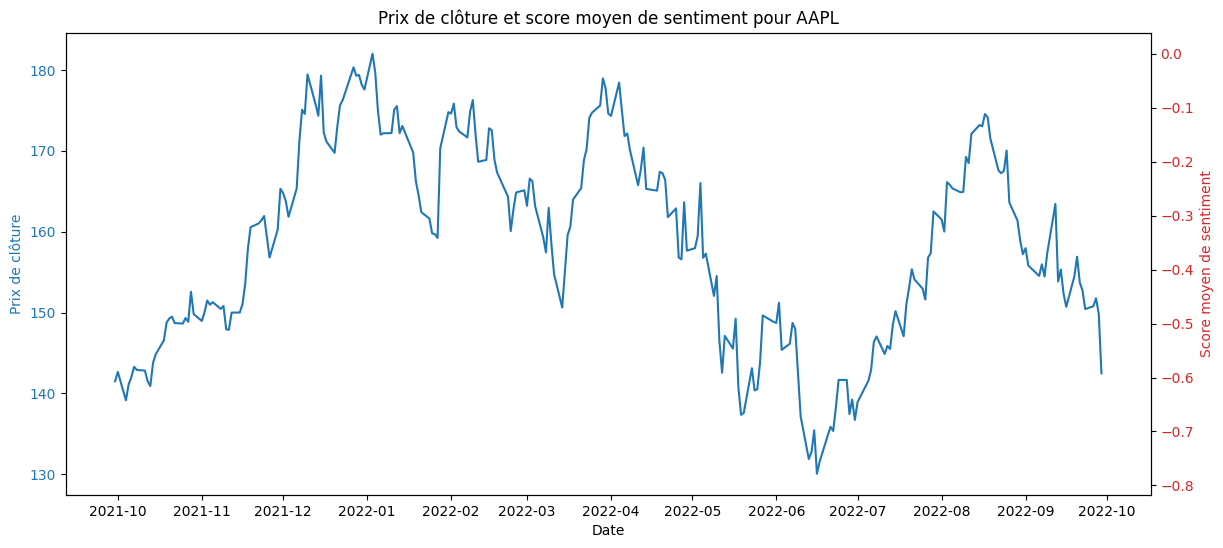

In [54]:
import matplotlib.dates as mdates

# Exemple pour un ticker spécifique, ex: 'AAPL'
ticker = 'AAPL'
df_ticker = merged_data[merged_data['Stock Name'] == ticker]

fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de clôture', color=color)
ax1.plot(df_ticker['Date'], df_ticker['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax2 = ax1.twinx()  # axe y secondaire

color = 'tab:red'
ax2.set_ylabel('Score moyen de sentiment', color=color)
ax2.plot(df_ticker['Date'], df_ticker['avg_sentiment_score'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Prix de clôture et score moyen de sentiment pour {ticker}")
plt.show()


In [55]:
# Corrélation entre prix de clôture et score moyen de sentiment (pour un ticker)
corr = df_ticker[['Close', 'avg_sentiment_score']].corr().iloc[0,1]
print(f"Corrélation Close vs Sentiment Score pour {ticker} : {corr:.3f}")


Corrélation Close vs Sentiment Score pour AAPL : -1.000


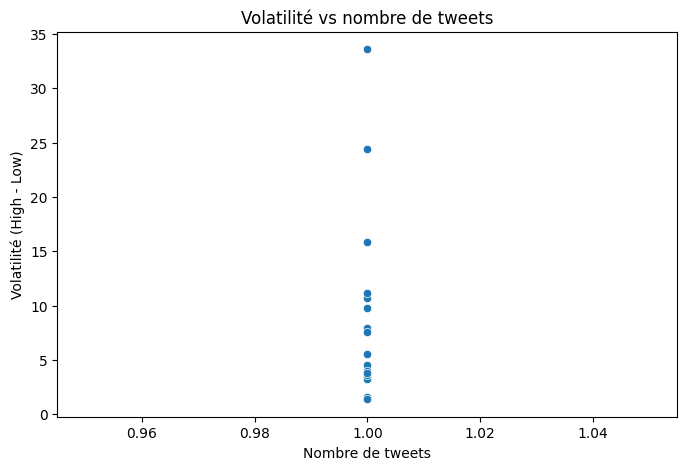

Corrélation Volatilité vs Nombre de tweets : nan


In [56]:
merged_data['volatility'] = merged_data['High'] - merged_data['Low']

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_data, x='tweet_count', y='volatility')
plt.title("Volatilité vs nombre de tweets")
plt.xlabel("Nombre de tweets")
plt.ylabel("Volatilité (High - Low)")
plt.show()

corr_vol_tweet = merged_data[['volatility', 'tweet_count']].corr().iloc[0,1]
print(f"Corrélation Volatilité vs Nombre de tweets : {corr_vol_tweet:.3f}")


In [57]:
# Calcul de volatilité
merged_data['volatility'] = merged_data['High'] - merged_data['Low']

# Conversion en numérique
merged_data['volatility'] = pd.to_numeric(merged_data['volatility'], errors='coerce')
merged_data['tweet_count'] = pd.to_numeric(merged_data['tweet_count'], errors='coerce')

# Supprimer les lignes avec NaN sur ces colonnes
valid_data = merged_data.dropna(subset=['volatility', 'tweet_count'])

# Vérifier la variance
if valid_data['volatility'].std() == 0 or valid_data['tweet_count'].std() == 0:
    print("Une des colonnes est constante, corrélation impossible.")
else:
    corr_vol_tweet = valid_data[['volatility', 'tweet_count']].corr().iloc[0,1]
    print(f"Corrélation Volatilité vs Nombre de tweets : {corr_vol_tweet:.3f}")


Une des colonnes est constante, corrélation impossible.


In [58]:
print(merged_data['volatility'].describe())
print(merged_data['tweet_count'].describe())


count    6300.000000
mean        5.859874
std         5.515611
min         0.160000
25%         1.930000
50%         4.224998
75%         8.049988
max        59.039978
Name: volatility, dtype: float64
count    16.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: tweet_count, dtype: float64


In [59]:
merged_data['tweet_count'] = merged_data['tweet_count'].fillna(0)


In [60]:
print(merged_data['volatility'].describe())
print(merged_data['tweet_count'].describe())

count    6300.000000
mean        5.859874
std         5.515611
min         0.160000
25%         1.930000
50%         4.224998
75%         8.049988
max        59.039978
Name: volatility, dtype: float64
count    6300.000000
mean        0.002540
std         0.050335
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: tweet_count, dtype: float64


In [61]:
print(f"Nombre de lignes merged_data : {len(merged_data)}")
print(f"Nombre de lignes avec tweet_count > 0 : {(merged_data['tweet_count'] > 0).sum()}")
print(f"Valeurs uniques de tweet_count : {merged_data['tweet_count'].unique()}")


Nombre de lignes merged_data : 6300
Nombre de lignes avec tweet_count > 0 : 16
Valeurs uniques de tweet_count : [0. 1.]


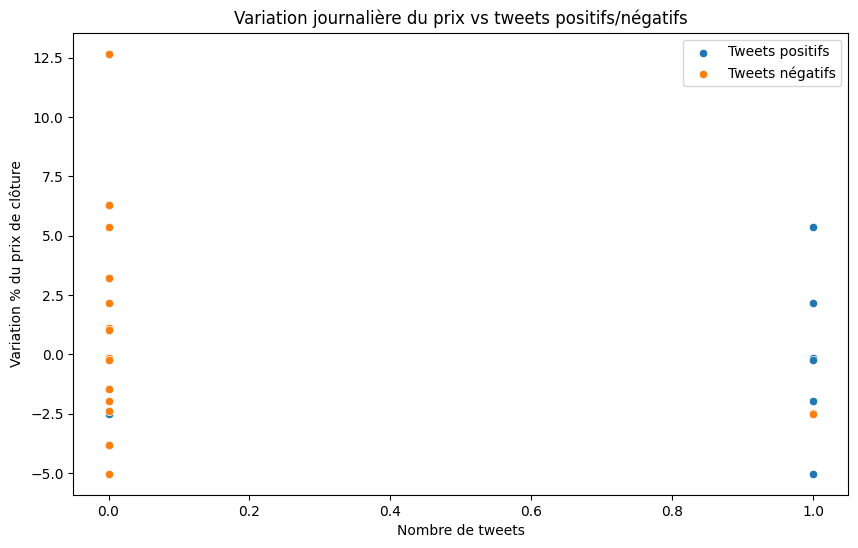

In [62]:
merged_data = merged_data.sort_values(['Stock Name', 'Date'])
merged_data['Close_pct_change'] = merged_data.groupby('Stock Name')['Close'].pct_change() * 100

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_data, x='positive_tweets', y='Close_pct_change', label='Tweets positifs')
sns.scatterplot(data=merged_data, x='negative_tweets', y='Close_pct_change', label='Tweets négatifs')
plt.title("Variation journalière du prix vs tweets positifs/négatifs")
plt.xlabel("Nombre de tweets")
plt.ylabel("Variation % du prix de clôture")
plt.legend()
plt.show()


In [ ]:
#%pip install vaderSentiment


### 6. Prétraitement - Encodage des labels

In [63]:
from sklearn.preprocessing import LabelEncoder

# Création de l'encodeur
label_encoder = LabelEncoder()

# Application sur la colonne Sentiment
tweets_data['Sentiment_Label'] = label_encoder.fit_transform(tweets_data['Sentiment'])

# On vérifie le mapping des labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)


{'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}


### 7. Modélisation Deep Learning avec LSTM

In [64]:
# Variables X et y
X = tweets_data['Clean_Tweet'].values
y = tweets_data['Sentiment_Label'].values


In [65]:
from sklearn.model_selection import train_test_split

# 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 7.1 Préparation des données

In [67]:
#vocab_size → combien de mots uniques on garde (plus = mieux, mais plus long à entraîner)
#max_length → longueur maximale des séquences (les plus longs seront coupés, les plus courts complétés)
vocab_size = 10000  # On garde les 10 000 mots les plus fréquents
max_length = 50  # Chaque tweet sera représenté par 50 tokens maximum
oov_token = "<OOV>"  # Token pour les mots inconnus


In [68]:
# Créer le tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# Apprendre le vocabulaire sur l'ensemble des textes d'entraînement
tokenizer.fit_on_texts(X_train)

# Convertir le texte en séquences numériques
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Appliquer le padding (compléter ou couper à max_length)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


### 7.2 Définition du modèle LSTM

In [70]:
embedding_dim = 64

model = Sequential()

# Couche d'embedding pour transformer les indices de mots en vecteurs
model.add(Embedding(vocab_size, embedding_dim))#, input_length=max_length))

# Couche LSTM pour traiter la séquence
model.add(LSTM(64, return_sequences=False))

# Petite couche Dropout pour éviter le surapprentissage
model.add(Dropout(0.5))

# Couche de sortie (classification 3 classes)
model.add(Dense(3, activation='softmax'))


In [71]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [72]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 7.3 Entraînement

In [73]:
# Entraînement
history = model.fit(
    X_train_padded,
    y_train,
    epochs=5,           # On démarre avec 5 époques (pour voir)
    batch_size=64,
    validation_data=(X_test_padded, y_test)
)


Epoch 1/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - accuracy: 0.5995 - loss: 0.8932 - val_accuracy: 0.8274 - val_loss: 0.5074
Epoch 2/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.8600 - loss: 0.4314 - val_accuracy: 0.8770 - val_loss: 0.3916
Epoch 3/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 61s 60ms/step - accuracy: 0.9064 - loss: 0.3216 - val_accuracy: 0.8868 - val_loss: 0.3780
Epoch 4/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step - accuracy: 0.9228 - loss: 0.2710 - val_accuracy: 0.8842 - val_loss: 0.3871
Epoch 5/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9308 - loss: 0.2381 - val_accuracy: 0.8862 - val_loss: 0.3863


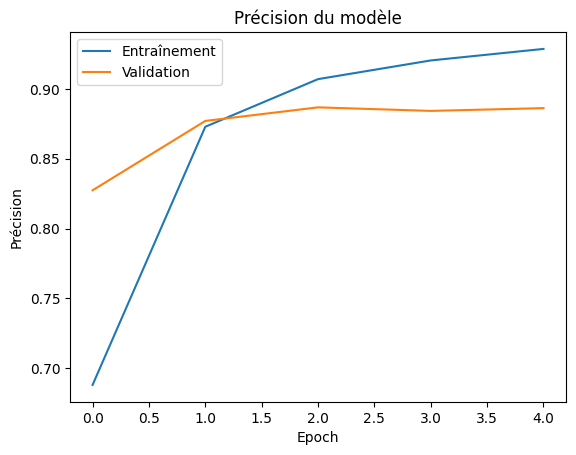

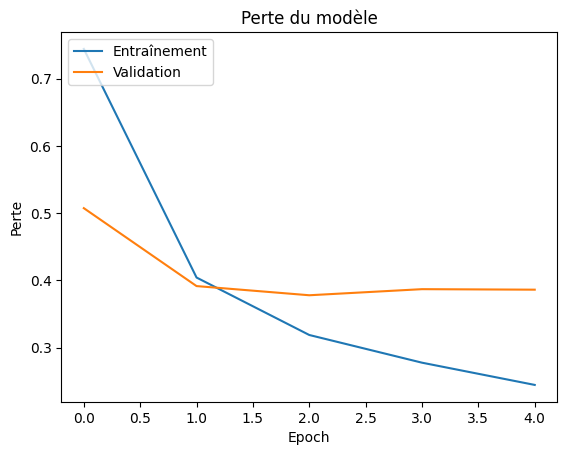

In [74]:
import matplotlib.pyplot as plt

# Évolution de la précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Évolution de la perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


In [75]:
import numpy as np

# Prédictions sur le set de test
y_pred_proba = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_proba, axis=1)


505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


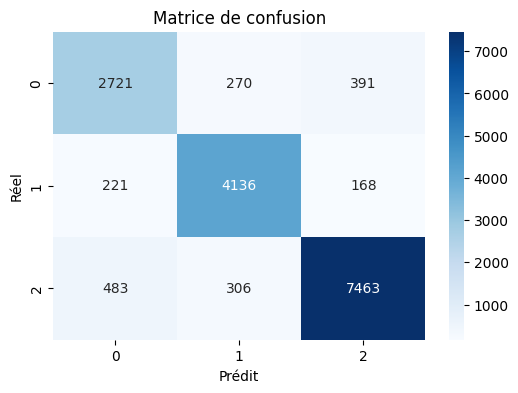

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


In [77]:
# Rapport de classification complet
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80      3382
     Neutral       0.88      0.91      0.90      4525
    Positive       0.93      0.90      0.92      8252

    accuracy                           0.89     16159
   macro avg       0.87      0.87      0.87     16159
weighted avg       0.89      0.89      0.89     16159



In [78]:
model.save('my_model.keras')
import pickle

# Sauvegarde du tokenizer
with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


### 8. Modélisation avec BERT (Transformers)

In [ ]:
'''%pip install torch torchvision torchaudio
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler #AdamW
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns'''


In [ ]:
'''# On va utiliser un modèle BERT classique
model_name = 'bert-base-uncased'

# Télécharger le tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained(model_name)


In [ ]:
'''# On récupère les textes nettoyés et les labels
texts = tweets_data['Clean_Tweet'].tolist()
labels = tweets_data['Sentiment_Label'].tolist()


In [ ]:
'''from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
'''# On définit une fonction pour tokenizer un lot de textes
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'  # Retourne des tenseurs PyTorch
    )


In [ ]:
'''# Tokenisation des jeux de données
train_encodings = tokenize_data(X_train, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

# Conversion des labels en tenseurs PyTorch
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)


In [ ]:
'''class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Création des datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)


In [ ]:
'''model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3  # car on a 3 classes (Negative, Neutral, Positive)
)


In [ ]:
'''from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
'''from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

# Calcul du nombre total d'epochs et de steps
epochs = 3
num_training_steps = epochs * len(train_loader)

from transformers import get_scheduler

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)



In [ ]:
'''# Vérification du device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("Device utilisé :", device)


In [ ]:
'''from tqdm import tqdm

# Mode entraînement
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())


In [ ]:
'''model.eval()
all_preds = []
all_labels = []

# Pas de gradient durant l'évaluation
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())


In [ ]:
'''from sklearn.metrics import classification_report

# Générer le rapport
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


In [ ]:
'''cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion BERT')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


In [ ]:
#  Prétraitement des dates 
tweets_data['Date'] = pd.to_datetime(tweets_data['Date']).dt.tz_localize(None)
finance_data['Date'] = pd.to_datetime(finance_data['Date']).dt.tz_localize(None)

In [ ]:
merged = pd.merge(tweets_data, finance_data, on='Date')

In [ ]:
# Création de la target Hausse/Baisse
merged = merged.sort_values(by='Date')
merged['Next_Close'] = merged['Close'].shift(-1)
merged['Target'] = (merged['Next_Close'] > merged['Close']).astype(int)
merged.dropna(inplace=True)

In [ ]:
# Sélection des features (que des valeurs numériques !)

features = ['Sentiment_Score', 'Open', 'High', 'Low', 'Close', 'Volume']
X = merged[features]
y = merged['Target']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardisation des données (indispensable en Deep Learning)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Découpage Train/Test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Construction du modèle Deep Learning

nb_features = X_train.shape[1]

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(nb_features,)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binaire

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Entraînement

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Sauvegarde du modèle
model.save("hausse_baisse_model.keras")

import joblib

# Sauvegarde du scaler
joblib.dump(scaler, "hausse_baisse_scaler.pkl")

#Test Accuracy: 72.50%


### 9. Modélisation avec DistilBERT (Transformers)

In [81]:
# version avec DistilBERT
#%pip install tf-keras
from .autonotebook import tqdm as notebook_tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


ImportError: attempted relative import with no known parent package

In [80]:
# Tokenisation
print("\n--- Initialisation DistilBERT ---")
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model_distil = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)



--- Initialisation DistilBERT ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Réutiliser les textes et labels nettoyés
texts = tweets_data['Clean_Tweet'].tolist()
labels = tweets_data['Sentiment_Label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})


In [ ]:
def tokenize_function(examples):
    return tokenizer_distil(examples["text"], padding="max_length", truncation=True)

# Tokenisation
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format torch
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
# Métriques de performance
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
# Entraînement
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model_distil,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("\n--- Entraînement de DistilBERT ---")
trainer.train()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_distilbert",
    evaluation_strategy="epoch",  # valide dans les versions récentes
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no"
)


In [ ]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


In [ ]:
# Évaluation finale
print("\n--- Évaluation finale DistilBERT ---")
eval_result = trainer.evaluate()
print("Résultats DistilBERT :", eval_result)

### 10. Modélisation avec FinBERT

In [ ]:
# DEEP lEARNING: BERT prediction hausse/baisse Test Accuracy: 76.92% 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Chargement du tokenizer et du modèle FinBERT
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")


merged['Clean_Tweet'] = merged['Tweet'].apply(clean_text)
merged['Clean_Tweet'] = merged['Tweet'].apply(clean_text)

In [ ]:
# Réduction de l’échantillon pour test FinBERT

sampled_data = merged.sample(n=390, random_state=42).copy()

In [ ]:
# Application de FinBERT

finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

def get_finbert_sentiment(text):
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = finbert_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    score = probs[0][2].item() - probs[0][0].item()  # Positive - Negative
    return score

sampled_data['FinBERT_Score'] = sampled_data['Tweet'].apply(get_finbert_sentiment)

In [ ]:
# Création de la target Hausse/Baisse

sampled_data = sampled_data.sort_values(by='Date')
sampled_data['Next_Close'] = sampled_data['Close'].shift(-1)
sampled_data['Target'] = (sampled_data['Next_Close'] > sampled_data['Close']).astype(int)
sampled_data.dropna(inplace=True)

In [ ]:
# Préparation du dataset final

features = ['FinBERT_Score', 'Open', 'High', 'Low', 'Close', 'Volume']
X = sampled_data[features]
y = sampled_data['Target']

In [ ]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Deep Learning modèle
nb_features = X_train.shape[1]

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(nb_features,)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

### 9. Déploiement avec Streamlit

In [ ]:
import streamlit as st
import tensorflow as tf
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Charger tes deux modèles
lstm_model = tf.keras.models.load_model('lstm_model.h5')
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Fonction pour prédire avec BERT
def predict_with_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    outputs = bert_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    prediction = torch.argmax(probs, dim=1).item()
    return prediction

# Fonction pour prédire avec LSTM
def predict_with_lstm(text, tokenizer, max_length=50):
    sequence = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = np.argmax(lstm_model.predict(padded), axis=1)
    return prediction[0]

# Interface Streamlit
st.title("Analyse de sentiment financier")

user_input = st.text_input("Entrez un tweet")

model_choice = st.selectbox("Choisissez le modèle :", ("LSTM", "BERT"))

if st.button("Prédire le sentiment"):
    if user_input:
        if model_choice == "LSTM":
            # ⚠️ ici il faudra passer ton tokenizer Keras
            sentiment = predict_with_lstm(user_input, tokenizer)
        else:
            sentiment = predict_with_bert(user_input)

        labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
        st.write("Sentiment prédit :", labels[sentiment])


In [ ]:
lstm_model.save('lstm_model.h5')


In [ ]:
"""
Application Streamlit pour l'analyse de sentiment
Ajout : prise en charge de deux modèles (LSTM et DistilBERT)
"""

import streamlit as st
import numpy as np
import tensorflow as tf
import pickle
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# -------------------------
# Chargement des modèles
# -------------------------

# Modèle LSTM
lstm_model = tf.keras.models.load_model('C:/Users/Lena/Desktop/deeplearning/my_model.keras')
with open('tokenizer_lstm.pkl', 'rb') as handle:
    lstm_tokenizer = pickle.load(handle)

# Modèle DistilBERT
@st.cache_resource
def load_distilbert_model():
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    return model, tokenizer

distilbert_model, distilbert_tokenizer = load_distilbert_model()
distilbert_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
distilbert_model.to(device)

# -------------------------
# Fonctions de prédiction
# -------------------------

def predict_lstm(text, tokenizer, max_length=50):
    sequence = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = np.argmax(lstm_model.predict(padded), axis=1)
    return prediction[0]

def predict_distilbert(text):
    inputs = distilbert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    return prediction

# -------------------------
# Interface Streamlit
# -------------------------

st.title("📊 Analyse de Sentiment Financier")

st.markdown("""
Cette application permet d'analyser le sentiment d'un tweet financier.
Choisissez le modèle que vous souhaitez utiliser :
""")

model_choice = st.selectbox("Modèle de prédiction :", ["LSTM (custom)", "DistilBERT"])
tweet = st.text_area("Entrez le texte du tweet :")

if st.button("Prédire"):
    if tweet.strip() != "":
        if model_choice == "LSTM (custom)":
            pred = predict_lstm(tweet, lstm_tokenizer)
        elif model_choice == "DistilBERT":
            pred = predict_distilbert(tweet)

        labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
        st.success(f"Sentiment prédit ({model_choice}) : {labels[pred]}")
    else:
        st.warning("Veuillez entrer un texte.")


In [ ]:
streamlit run app.py
